# Using TensorRT in UbiOps

UbiOps provides the perfect infrastructure to run your machine learning models with NVIDIA TensorRT.

**On this page, we will show how to run an inference job with TensorRT on UbiOps!**

We will create a deployment where TensorRT is running, upload a model that uses TensorRT and then show the speed differences between running this model with TensorRT, CUDA or only the CPU. TensorRT and CUDA will be tested on 2 different GPU's; the NVIDIA T4 and the NVIDIA A100.

### **Model**  
The model used will be the [Resnet152 ONNX model](https://github.com/onnx/models/tree/main/vision/classification/resnet), pretrained on the [ImageNet database](https://www.image-net.org/). This pretrained model is used to classify images to 1000 different classes.

This model will be run with different inference engines (TensorRT, CUDA, CPU) by making use of the [ONNX Runtime Python package](https://onnxruntime.ai/docs/get-started/with-python.html), all inside UbiOps.

The following software stack will be used inside UbiOps:  


| Technology           | Version      |
|----------------------|--------------|
| Operating System     | Ubuntu 22.04 |
| Python Version       | 3.10         |
| CUDA Version         | 11.7.1       |



**Note: GPU Access is needed inside UbiOps!**

## 1) Set project variables and initialize the UbiOps API Client
First, make sure you create an **API token** with `project editor` permissions in your UbiOps project and paste it below. Also fill in your corresponding UbiOps project name. 

In [ ]:
import yaml
import os

API_TOKEN = (
    "<insert-your-token-here>"  # Make sure this is in the format "Token token-code"
)
PROJECT_NAME = "<your-project-name>"  # Fill in the corresponding UbiOps project name
DEPLOYMENT_NAME = (
    "tensorrt-infer-tutorial"  # You can change this to any name for the deployment
)
DEPLOYMENT_VERSION_TENSORRT_T4 = "tensorrt-t4"  # Choose a name for the version. We use `tensorrt-t4` here, as we're gonna use TensorRT on a NVIDIA T4 GPU

ubiops_package_name_tensorrt = "ubiops_tensorrt_inference_pkg"
if not os.path.exists(ubiops_package_name_tensorrt):
    # This will create a new local folder to use for deployment files later
    os.makedirs(ubiops_package_name_tensorrt)

print(f"Your new deployment will be called: {DEPLOYMENT_NAME}.")

### Initialize the UbiOps client library with the API token
Now we import the UbiOps Python client and authenticate with the API. You can install it with `pip install ubiops`

In [ ]:
!pip install -qU ubiops

import ubiops

configuration = ubiops.Configuration(host="https://api.ubiops.com/v2.1")
configuration.api_key["Authorization"] = API_TOKEN

client = ubiops.ApiClient(configuration)
api = ubiops.CoreApi(client)
api.service_status()

***
## 2) Setup deployment environment
In order to make TensorRT running inside the deployment, we need to set up the environment of the deployment so that everything will run smoothly. This will be done by specifying the `requirements.txt` and the `ubiops.yaml` file.


### a) Requirements.txt file
The `requirements.txt` file lists all the necessary packages that have to be installed in the deployment container. UbiOps will install these packages automatically for you.

In [ ]:
%%writefile ubiops_tensorrt_inference_pkg/requirements.txt

onnx==1.13.1
onnxruntime-gpu==1.14.1
tensorrt==8.5.3.1
numpy
Pillow

### b) ubiops.yaml file
The `ubiops.yaml` file is used to install additional software packages and set environment variables. The latter is what we're after.  
We will specify where TensorRT is installed this way!

In [ ]:
%%writefile ubiops_tensorrt_inference_pkg/ubiops.yaml

environment_variables:
  - LD_LIBRARY_PATH=/var/deployment_instance/venv/lib/python3.10/site-packages/tensorrt/:${LD_LIBRARY_PATH}


***
## 3) Deployment code

The code used will be put inside a `deployment.py` file. This code will be run when a call to the deployment is made.  

We will set up the `deployment.py` in such a way that it expects a file path as input.  
The output will be an array of 5 strings with the top 5 predicted classes and their probabilities. The inference time will also be given in the output 

The model input is contained in the `data` variable, which is a dictionary. We will return a dictionary including the array of top 5 predicted classes and the inference time:
***
| Deployment input & output variables |                   |                    |
|-------------------------------------|-------------------|--------------------|
|                                     | **Variable name** | **Data type**      |
| **Input fields**                    | file              | File               |
| **Output fields**                   | predictions       | Array of Strings   |
|                                     | time              | Double precision   |

***
The following code will be used:

In [ ]:
%%writefile ubiops_tensorrt_inference_pkg/deployment.py

import os
import time
import urllib.request

import numpy as np
import onnxruntime as rt
from PIL import Image


class Deployment:
    def __init__(self, base_directory, context):
        # Check if the model exists
        if not os.path.exists('resnet152-v2-7.onnx'):
            # Download the model
            print('Downloading model...')
            urllib.request.urlretrieve(
                'https://zenodo.org/records/4735647/files/resnet50_v1.onnx?download=1',
                'resnet152-v2-7.onnx'
            )
            print('Model downloaded')

        # Check if the labels file exists
        if not os.path.exists('synset.txt'):
            # Download the labels file
            print('Downloading labels...')
            urllib.request.urlretrieve(
                'https://raw.githubusercontent.com/google/inception/master/synsets.txt',
                'synset.txt'
            )
            print('Labels downloaded')

        # Load the model and set available providers - TensorRT, CUDA, CPU
        self.sess = rt.InferenceSession('resnet152-v2-7.onnx',
                                        providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider',
                                                   'CPUExecutionProvider'])

        # Define input and output names
        self.input_name = self.sess.get_inputs()[0].name
        self.output_name = self.sess.get_outputs()[0].name

        # Load the labels file
        with open('synset.txt', 'r') as f:
            self.labels = [line.strip() for line in f.readlines()]

    def request(self, data):
        # Open the image using PIL
        img = Image.open(data['file'])

        # Resize the image to the input size expected by the model
        img = img.resize((224, 224))

        # Convert the image to a numpy array
        img = np.asarray(img)

        # Convert the image to the format expected by the model (RGB, float32)
        img = img[:, :, :3]  # remove alpha channel if present
        img = img.transpose((2, 0, 1))  # change from HWC to CHW format
        img = img.astype(np.float32) / 255.0  # normalize pixel values to [0, 1]

        # Normalize using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
        img[0] = (img[0] - 0.485) / 0.229
        img[1] = (img[1] - 0.456) / 0.224
        img[2] = (img[2] - 0.406) / 0.225

        img = np.expand_dims(img, axis=0)  # add batch dimension

        # Run inference and time it
        start = time.time()
        output = self.sess.run([self.output_name], {self.input_name: img})[0].flatten()
        end = time.time()
        inference_time = end - start

        # Get the top 5 predicted classes and their probabilities
        top_idx = np.argsort(output)[::-1][:5]
        top_prob = output[top_idx]

        # Create the predictions
        predictions = [f'{i + 1}. {self.labels[top_idx[i]]}: {top_prob[i]:.3f}' for i in range(min(5, len(top_idx)))]

        # Return the predictions and the inference time
        return {
            'predictions': predictions,
            'time': inference_time
        }

***
## 4) Define and create the deployment in UbiOps
We will now use the Python client to define a new deployment in UbiOps with the input and output definitions as mentioned earlier

In [ ]:
deployment_template = ubiops.DeploymentCreate(
    name=DEPLOYMENT_NAME,
    input_type="structured",
    output_type="structured",
    input_fields=[{"name": "file", "data_type": "file"}],
    output_fields=[
        {"name": "predictions", "data_type": "array_string"},
        {"name": "time", "data_type": "double"},
    ],
)

api.deployments_create(project_name=PROJECT_NAME, data=deployment_template)

### Create a deployment version
Next we create a version for the deployment. For the version we set the name, environment and size of the instance (we're using a GPU instance here, check if the instance type specified here is available!).

In [ ]:
template_tensorrt_t4 = {
    "version": DEPLOYMENT_VERSION_TENSORRT_T4,
    "environment": "ubuntu22-04-python3-11-cuda11-7-1",
    "instance_type_group_name": "16384 MB + 4 vCPU + NVIDIA Tesla T4",
    "maximum_instances": 1,
    "minimum_instances": 0,
    "maximum_idle_time": 300,
}
api.deployment_versions_create(
    project_name=PROJECT_NAME,
    deployment_name=DEPLOYMENT_NAME,
    data=template_tensorrt_t4,
)

***
## 5) Package and upload the code
Now we have the deployment and version defined, we can upload the actual code to it. We zip and upload the folder containing the `requirements.txt`, `ubiops.yaml` and `deployment.py` files. As we do this, UbiOps will build a container based on the settings above and install all packages defined in our requirements file. 

**This process can take a few minutes!**

<div class="alert alert-block alert-info"><b>Tip:</b> You can also check the status in the UbiOps browser UI by navigating to the deployment version and clicking the `logs` icon. </div>

In [ ]:
import shutil

zip_dir_tensorrt = shutil.make_archive(
    "deployment_package_tensorrt", "zip", ubiops_package_name_tensorrt
)

In [ ]:
# Upload the directory with model files to UbiOps
upload_response = api.revisions_file_upload(
    project_name=PROJECT_NAME,
    deployment_name=DEPLOYMENT_NAME,
    version=DEPLOYMENT_VERSION_TENSORRT_T4,
    file=zip_dir_tensorrt,
)
print(upload_response)

### Wait for the deployment to be ready

In [ ]:
ubiops.utils.wait_for_deployment_version(
    client=api.api_client,
    project_name=PROJECT_NAME,
    deployment_name=DEPLOYMENT_NAME,
    version=DEPLOYMENT_VERSION_TENSORRT_T4,
    revision_id=upload_response.revision,
)

***
## 6) Create a request to the model API in UbiOps to start a training run

Now it's time to make a request! Since we use a file as input, we first need to upload our file to UbiOps. Let's download a random sample image from the [imagenet-sample-images](https://github.com/EliSchwartz/imagenet-sample-images) Github repository.

In [ ]:
import requests
import random

# Set url for Github API endpoint
url = "https://api.github.com/repos/EliSchwartz/imagenet-sample-images/contents/"

# Send request
data = requests.get(url).json()

# Get random image download url from the data
download_url = data[random.randint(2, len(data))]["download_url"]

# download the image
response = requests.get(download_url)

# save the image to disk
with open("image.jpg", "wb") as f:
    f.write(response.content)

Now we can see if the image has downloaded correctly and show it!

In [ ]:
from IPython.display import Image

Image("image.jpg")

Let's upload this image to Ubiops and create a direct request!

In [ ]:
ubiops_file_url = ubiops.utils.upload_file(
    client=client, project_name=PROJECT_NAME, file_path="image.jpg"
)
print(f"Image file: {ubiops_file_url}")

data = {"file": ubiops_file_url}

request_response = api.deployment_version_requests_create(
    project_name=PROJECT_NAME,
    deployment_name=DEPLOYMENT_NAME,
    version=DEPLOYMENT_VERSION_TENSORRT_T4,
    data=data,
)
print("Request finished!")

Let's parse the output in a nice to read format!

In [ ]:
print("Predictions:")
for pred in request_response.result["predictions"]:
    print("- " + pred)
print("Time: " + str(request_response.result["time"]))

Try running a request multiple times to see the effect of the TensorRT start-up time and the inference time when the model has been built!

The preceding code has been benchmarked with different inference engines and hardware setups (different GPUs).  
The start-up times and inference times can be seen in the following figures:

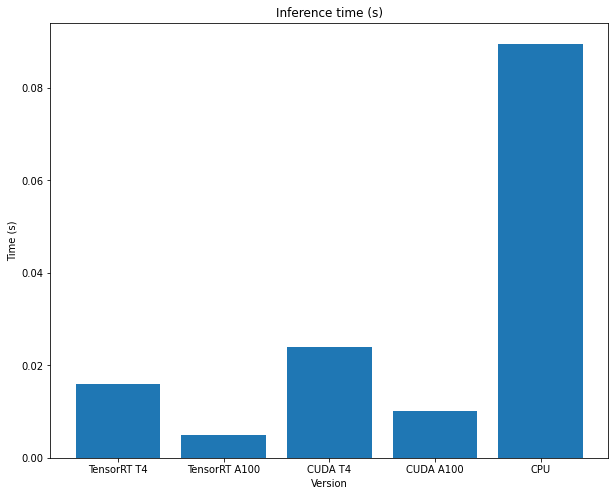



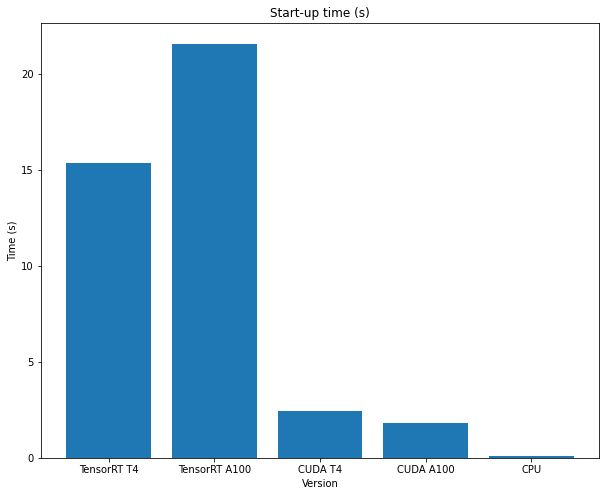

## 7) Cleanup

Close the connection with the UbiOps API client.

In [ ]:
client.close()